In [64]:
import pandas as pd
import math
import numpy as np
from scipy import stats

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_theme(style='whitegrid')

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, balanced_accuracy_score
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE, RandomOverSampler
import xgboost as xgb

In [2]:
# Defining Thresholds and Scoring Function
u_CNT = list(range(0,11))+[2*x for x in range(6,16)]+[10*x for x in range(4,11)]
u_BA  = [0,1]+[10*x for x in range(1,11)]+[50*x for x in range(3,7)]+[400,500,1000,1500,2000,5000]+[10000*x for x in range(1,6)]+[100000]

w_CNT = [1-(1+(x+1)**2/1000)**(-1/4) for x in u_CNT] 
w_CNT = [x/w_CNT[-1] for x in w_CNT] 

w_BA  = [1-(1+(x+1)/1000)**(-1/4) for x in u_BA]
w_BA  = [x/w_BA[-1] for x in w_BA]

def ba_score(y_test, prediction_dist):  
    S_BA  = 0
    for i in range(len(y_test)):
        S_BA = S_BA + np.sum([w_BA[x]*(int(u_BA[x]>=y_test.iloc[i])-prediction_dist.iloc[i,x])**2 for x in range(len(u_BA))])
    return S_BA

In [55]:
# Loading data
data = pd.read_csv('data/data_train_DF.csv')
data.drop('Unnamed: 0', axis=1, inplace=True)

# Replacing clim1 and clim2 by wind
data['wind'] = np.sqrt(data.clim1**2+data.clim2**2)
data.drop(['clim1','clim2'], axis=1, inplace=True)

# Adding relative humidity
data['RH'] = 100 * np.exp(17.625*(data.clim3-273.15)/(data.clim3-39.11)) / np.exp(17.625*(data.clim4-273.15)/(data.clim4-39.11))

# Changing month to factor and dropping area and year
data.drop(['area','year'], axis=1, inplace=True)
### BUGS CORRECT LATER : data['month'] = data['month'].astype('category')

# Dropping NA in new dataframe
data_validation = data[data.BA.isna() | data.CNT.isna()]
data.dropna(inplace=True)

# List of labels by type
clim_labels = ['altiMean', 'altiSD', 'clim3', 'clim4', 'clim5', 'clim6', 'clim7', 'clim8','clim9', 'clim10', 'wind', 'RH']
land_labels = ['lc1','lc2','lc3','lc4','lc5','lc6','lc7','lc8','lc9','lc10','lc11','lc12','lc13','lc14','lc15','lc16','lc17','lc18']

# Splitting data to train/test
X_train, X_test, y_train, y_test = train_test_split(data.drop('BA', axis=1), data['BA'], test_size=0.9, random_state=42)

# Standardizing climate variables
scaler = StandardScaler()
X_train[land_labels+clim_labels] = scaler.fit_transform(X_train[land_labels+clim_labels])
X_test[land_labels+clim_labels]  = scaler.fit_transform(X_test[land_labels+clim_labels])

# Adding mean CNT per voxel
mean_CNT_voxel = X_train.groupby(['lon','lat'])[['CNT']].mean()
X_train['mean_fire'] = X_train.apply(lambda x: mean_CNT_voxel.loc[x.lon,x.lat], axis=1)
X_test['mean_fire']  = X_test.apply(lambda x: mean_CNT_voxel.loc[x.lon,x.lat], axis=1)

# Summary
1. Classify BA into 3 classes : 0 or 0-T or >T (T the threshold)
2. Model BA in 0-T
3. Model BA >T

In [56]:
# Classification threshold
threshold = 200

# Class encoding of y_train/y_test 
new_y_train = y_train.apply(lambda x: 0 if x==0 else 1 if x<=threshold else 2)
new_y_test  = y_test.apply(lambda x: 0 if x==0 else 1 if x<=threshold else 2)

print('X_train shape :', X_train.shape, '\nX_test shape  :', X_test.shape)

X_train shape : (45293, 35) 
X_test shape  : (407637, 35)


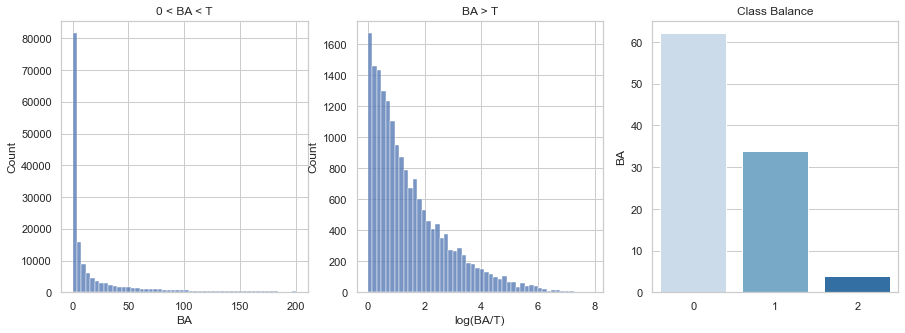

In [57]:
# Visualisation of the problem
fig, ax = plt.subplots(1,3, figsize=(15,5))

sns.histplot(x=data[(data.BA>0) & (data.BA<=threshold)].BA, log_scale=False, bins=50, ax=ax[0])
ax[0].set_xlabel('BA')
ax[0].set_title('0 < BA < T')

sns.histplot(x=np.log(data[data.BA>threshold].BA/threshold), log_scale=False, bins=50, ax=ax[1])
ax[1].set_xlabel('log(BA/T)')
ax[1].set_title('BA > T')

sns.barplot(x=[0,1,2], y=100*new_y_train.value_counts(normalize=True), palette='Blues', ax=ax[2])
ax[2].set_title('Class Balance');

In [86]:
weights = new_y_train.value_counts()

under = RandomUnderSampler(sampling_strategy={0:int(0.95*weights[2]), 1:int(weights[1]/5), 2:weights[2]}, random_state=42)
under = RandomUnderSampler(sampling_strategy={0:int(weights[1]), 1:int(weights[1]), 2:int(weights[2])}, random_state=42)

over  = SMOTE(random_state=42)
over  = RandomOverSampler(random_state=42)

X_s, y_s = under.fit_resample(X_train.drop(['CNT'], axis=1), new_y_train)

print(f'''Shape of X before SMOTE: {X_train.drop(['CNT'], axis=1).shape}''')
print(f'''Shape of X after  SMOTE: {X_s.shape}''')
print('\nBalance of positive and negative classes (%):')
y_s.value_counts(normalize=True) * 100

Shape of X before SMOTE: (45293, 34)
Shape of X after  SMOTE: (84321, 34)

Balance of positive and negative classes (%):


2    33.333333
1    33.333333
0    33.333333
Name: BA, dtype: float64

In [87]:
#clf = RandomForestClassifier(max_depth=6, n_estimators=500, n_jobs=8, bootstrap=False, max_features=None, class_weight='balanced', random_state=42)
#clf = lm.LogisticRegression(max_iter=200, solver='lbfgs', class_weight={0:1, 1:3, 2:2}, n_jobs=8, random_state=42)
clf = MLPClassifier(max_iter=300, activation='relu', alpha=0.01, learning_rate='adaptive', hidden_layer_sizes=100, random_state=42)

pipe = Pipeline([('pca', PCA()), ('clf', clf)])

pipe.fit(X_s, y_s)

print('ACCURACY %2.0f %%' % (100*pipe.score(X_test.drop(['CNT'], axis=1), new_y_test)))

acl = [100*accuracy_score(pipe.predict(X_test[new_y_test==c].drop(['CNT'], axis=1)), new_y_test[new_y_test==c]) for c in [0,1,2]]
print('ACCURACY CLASS 0: %2.0f %% - 1: %2.0f %% - 2: %2.0f %%' % (acl[0],acl[1],acl[2]))

print('BALANCED ACCURACY %2.0f %%' % 
      (100*balanced_accuracy_score(pipe.predict(X_test.drop(['CNT'], axis=1)), new_y_test, adjusted=True)))

ACCURACY 72 %
ACCURACY CLASS 0: 78 % - 1: 65 % - 2: 45 %
BALANCED ACCURACY 35 %


In [68]:
# Prediction Class Probabilities
p_class = pipe.predict_proba(X_test.drop(['CNT'], axis=1))
pd.DataFrame(p_class).head(11).T

,0,1,2,3,4,5,6,7,8,9,10
0,0.035758,0.454625,0.003956,0.096765,0.265712,0.726694,0.617609,0.163774,0.997796,0.511424,0.935568
1,0.572891,0.532788,0.523996,0.900340,0.705106,0.268319,0.381984,0.834643,0.002202,0.487655,0.064259
2,0.391351,0.012587,0.472048,0.002894,0.029183,0.004987,0.000407,0.001582,0.000002,0.000921,0.000173


In [101]:
# Preparing data for xgboost
dtrain = xgb.DMatrix(X_train[(y_train>0)&(y_train<=threshold)].drop(['CNT'], axis=1), label=y_train[(y_train>0)&(y_train<=threshold)])
dtest = xgb.DMatrix(X_test[(y_test>0)&(y_test<=threshold)].drop(['CNT'], axis=1), label=y_test[(y_test>0)&(y_test<=threshold)])

# Performance Evalution
evallist = [(dtest, 'eval'), (dtrain, 'train')]

# Parameters
param = {'max_depth': 2, 
         'eta': 1, 
         'objective': 'reg:gamma',
         'nthread': 4,
         'eval_metric': 'mape'
        }

In [103]:
num_round = 10
bst = xgb.train(param, dtrain, num_round, evallist)

[0]	eval-mape:3.78233	train-mape:3.46789
[1]	eval-mape:8.76490	train-mape:8.04609
[2]	eval-mape:18.39521	train-mape:16.96952
[3]	eval-mape:31.68332	train-mape:29.25450
[4]	eval-mape:39.61291	train-mape:36.96063
[5]	eval-mape:40.93997	train-mape:38.34636
[6]	eval-mape:37.73665	train-mape:35.19300
[7]	eval-mape:33.54094	train-mape:31.16194
[8]	eval-mape:33.85800	train-mape:31.50171
[9]	eval-mape:33.53533	train-mape:31.12819


In [105]:
ypred = bst.predict(dtest)
ypred

array([ 8.303788 , 38.776615 , 38.716034 , ...,  5.999901 ,  1.7095772,
        0.9560327], dtype=float32)

In [109]:
ypred, y_test[(y_test>0)&(y_test<=threshold)]

(array([ 8.303788 , 38.776615 , 38.716034 , ...,  5.999901 ,  1.7095772,
         0.9560327], dtype=float32),
 336693     2.920000
 52432     53.000000
 361818    32.599998
 214696     0.500000
 326868     3.600000
             ...    
 3449      38.500000
 316643     2.000000
 19531     30.200001
 17716      0.010000
 362077     0.100000
 Name: BA, Length: 139682, dtype: float64)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

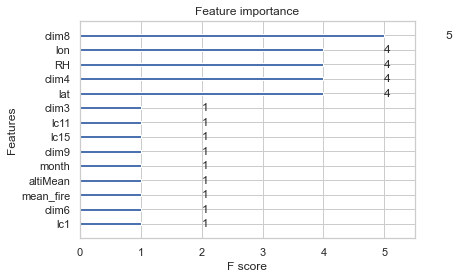

In [110]:
xgb.plot_importance(bst)